In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import re
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['DGLBACKEND'] = "pytorch"

try:
    import dgl
    installed = True
except ImportError:
    installed = False
print("DGL installed!" if installed else "DGL not found!")

DGL installed!


In [ ]:
import dgl.sparse as dglsp  # Assuming you're using dgl for graph operations
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import networkx as nx
import numpy as np

# Feature engineering and preprocessing (replace with your specific logic)
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Or other suitable scalers
from sklearn.decomposition import PCA  # For dimensionality reduction (optional)
from sklearn.feature_selection import SelectKBest, f_regression  # For feature selection (optional)

# Machine learning and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Data I/O and persistence (replace with your specific logic)
import pandas as pd

import pickle  # Or h5py, joblib, depending on preference
import os

# Text processing (if applicable)
import re


In [ ]:
# Define your GCN model
class GCN(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=16):
        super().__init__()
        self.W1 = nn.Linear(in_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, out_size)

    def forward(self, A_norm, X):
        X = A_norm @ self.W1(X)
        X = F.relu(X)
        X = A_norm @ self.W2(X)
        return X

In [ ]:
def load_data(filename):  #đọc vector đặc trưng
    with open(filename, "r") as f:
        vector_code = f.read()
    vector_list = re.findall(r'\[([^\[\]]+)\]', vector_code)
    vectors = [[float(num) for num in vector.split()] for vector in vector_list]



    return vectors

In [ ]:
def load_adj(gexf_path,X_tensor):
    #Đọc fcg từ file gexf
    graph = nx.read_gexf(gexf_path)
    # Xây dựng ma trận kề từ đồ thị
    A = nx.adjacency_matrix(graph).todense()
    #Chuyển A thành tensor
    A_tensor=torch.tensor(A)
    indices = A_tensor.to_sparse()._indices()  #ma trận tọa độ
    values = A_tensor.to_sparse()._values() #ma trận giá trị
    N = X_tensor.shape[0]  #số node
    A_sparse = dgl.sparse.spmatrix(indices, values, (N, N))  #tạo ma trận sparse từ tensor để đồng bộ với các ma trận khác phục vụ tính toán
    A_sparse = A_sparse.float() #chuyển ma trận sang float để cùng kiểu với các ma trận khác
    return A_sparse;

In [ ]:
def train_unsupervised(model, A_norm, X, num_epochs=100):
    optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

    for epoch in range(num_epochs):
        model.train()
        logits = model(A_norm, X)
        reconstruction_loss = F.mse_loss(logits, X)
        optimizer.zero_grad()
        reconstruction_loss.backward()
        optimizer.step()

In [ ]:
tung_dir = "/content/drive/MyDrive/ATBM/Tung"

#benign2
# input_dir = tung_dir+"/vec_benign"
# adj_dir= tung_dir+"/fcg_benign"
# adj_dir = tung_dir+"/BTL_ATBM_MINH/op_fcg_benign_final" # Thay adj_dir moi, la fcg ben folder Minh
# output_dir = tung_dir+"/output_gcn_benign"

#benign Thong
# input_dir = "/content/drive/MyDrive/ATBM/DOC2VEC_output/GCN/vec_benign"
# adj_dir= tung_dir+"/BTL_ATBM_MINH/op_fcg_benign_final"
# output_dir = tung_dir+"/output_gcn_benign"

#malware Thong
# input_dir = tung_dir+"/outputmalwaredoc2vec"
# adj_dir= tung_dir+"/GCN/fcgGCN/output_fcg_mal"
# output_dir = tung_dir+"/output_gcn_malware"

# #malware Minh PROCESSING
input_dir = "/content/drive/MyDrive/ATBM/DOC2VEC_output/btl_minh_2/vec_malware"
adj_dir= "/content/drive/MyDrive/ATBM/DOC2VEC_output/btl_minh_2/final_mal_fcg"
output_dir = tung_dir+"/output_gcn_malware"

def count_files(dir):
  print(f"Count file in {dir} : {len(os.listdir(dir))}")
count_files(input_dir)
count_files(adj_dir)
count_files(output_dir)

Count file in /content/drive/MyDrive/ATBM/DOC2VEC_output/btl_minh_2/vec_malware : 3609
Count file in /content/drive/MyDrive/ATBM/DOC2VEC_output/btl_minh_2/final_mal_fcg : 4089
Count file in /content/drive/MyDrive/ATBM/Tung/output_gcn_malware : 1375


In [ ]:
# import os
# import torch
# from tqdm import tqdm

# total_files = len(os.listdir(input_dir))

# def process_data(input_dir):

#     num_small_files = 0

#     with tqdm(total=total_files, desc="Processing data") as progress_bar:
#         for filename in os.listdir(input_dir):
#             input_path = os.path.join(input_dir, filename)
#             X = load_data(input_path)
#             X_tensor = torch.tensor(X)

#             if X_tensor.shape[0] < 30:
#                 num_small_files += 1

#             progress_bar.update(1)  # Update progress bar for each file

#     return num_small_files

# # Example usage
# num_small_files = process_data(input_dir)
# print(f"Number of files with less than 100 elements: {num_small_files}/{total_files}")

# 100
# Processing malware data: 100%|██████████| 1663/1663 [01:06<00:00, 25.01it/s]Number of files with less than 100 elements: 1144/1663
# Processing data: 100%|██████████| 330/330 [01:37<00:00,  3.39it/s]Number of files with less than 100 elements: 7/330

# 50
# Processing data: 100%|██████████| 330/330 [01:07<00:00,  4.88it/s]Number of files with less than 50 elements: 4
# Processing data: 100%|██████████| 1663/1663 [01:24<00:00, 19.71it/s]Number of files with less than 50 elements: 1102/1663

# 30
# Processing mal data: 100%|██████████| 1663/1663 [01:21<00:00, 20.36it/s]Number of files with less than 30 elements: 9/1663

In [ ]:
for filename in os.listdir(input_dir):
  if filename.endswith(".txt"):
      # print(f"Processing {filename}")
      input_path = os.path.join(input_dir, filename)
      output_path = os.path.join(output_dir, filename)

      if "(" in filename: continue
      if os.path.exists(output_path):
          print(f"{output_path} exists. Skipping training.")
          continue
      if os.path.getsize(input_path) == 0:
          print(f"Input file {input_path} is empty. Skipping training.")
          continue

      # Load data from input file
      X = load_data(input_path)
      X_tensor = torch.tensor(X)
      if X_tensor.shape[0] < 100:
          print(f"Number of nodes in {filename} is less than 100. Skipping training.")
          continue
      # Create adjacency matrix
      # Construct file path for gexf file
      gexf_filename = os.path.splitext(filename)[0] + ".gexf"
      gexf_path = os.path.join(adj_dir, gexf_filename)
      A_sparse = load_adj(gexf_path, X_tensor)

      I = dgl.sparse.identity(A_sparse.shape)
      A_hat = A_sparse + I
      D_hat = dgl.sparse.diag(A_hat.sum(1)) ** -0.5
      A_norm = D_hat @ A_hat @ D_hat
      # Create GCN model
      in_size = X_tensor.shape[1]
      num_classes = 100
      model = GCN(in_size, num_classes)
      train_unsupervised(model, A_norm, X_tensor)

      # Perform feature selection
      with torch.no_grad():
          model.eval()
          output = model(A_norm, X_tensor)
          output_mean = torch.mean(output, dim=1, keepdim=True)
          output_np = output.squeeze().numpy()

          # Select top 100 important features
          selector = SelectKBest(score_func=f_regression, k=100)
          dummy_y = np.zeros(output_np.shape[0])
          selector.fit(output_np, y=dummy_y)
          indices = selector.get_support(indices=True)

          # Select top 100 nodes based on mean output
          selected_nodes = output_mean[indices]

          # Write selected nodes to output file
          with open(output_path, "w") as f:
              for node in selected_nodes:
                  node_str = " ".join([str(val.item()) for val in node])
                  f.write(node_str + "\n")
          print(f"Saved {filename}")
          output_files_count = len(os.listdir(output_dir))
          print(f"Count file in output : {output_files_count}")
print("DONE")

/content/drive/MyDrive/ATBM/Tung/output_gcn_malware/05F61F4541CDF7CEE55F5C57DFE93125C498A5ABE85480A252BD629EE324331F.txt exists. Skipping training.
Number of nodes in 0604B9DF675349B2361994F4BEC8920ADE3A76528BF017C038F668EE8D283F4A.txt is less than 100. Skipping training.
Number of nodes in 0670BA1F2D2E8ED666A34CFAC282224CD8A657632E3916CDC0AF71E907C251E1.txt is less than 100. Skipping training.
Number of nodes in 064BC5FD03567DB6A1DD7AF74413A0FC7EA0976C88F02A92C25791F6BB1B11D7.txt is less than 100. Skipping training.
Number of nodes in 06082501DFD392715411659EAA5392034046963A6CBE9578D06E6C59CB1211FB.txt is less than 100. Skipping training.
Number of nodes in 0630C855AB3500644FA27F379CFE7E547A7DEC5911B8F60C9B20CCE31895E52B.txt is less than 100. Skipping training.
Number of nodes in 0642BFCA501FB36E2D874C1537C072DDD52AF57CBB23E4572734DA70F714551D.txt is less than 100. Skipping training.
Number of nodes in 067BABD54126284673248E41F7B2F7B64685CA9975AEF67A424914EEE3895E6F.txt is less than 1

In [ ]:
output_gcn_b = "/content/drive/MyDrive/ATBM/Tung/output_gcn_benign"
output_gcn_m = "/content/drive/MyDrive/ATBM/Tung/output_gcn_malware"

count_files(output_gcn_b)
count_files(output_gcn_m)
# Count file in /content/drive/MyDrive/ATBM/Tung/output_gcn_benign : 960
# Count file in /content/drive/MyDrive/ATBM/Tung/output_gcn_malware : 1375


Count file in /content/drive/MyDrive/ATBM/Tung/output_gcn_benign : 960
Count file in /content/drive/MyDrive/ATBM/Tung/output_gcn_malware : 1482


# RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
import itertools
import os
import re
import pickle
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix

In [ ]:
def read_txt_file(filepath):
    with open(filepath, 'r') as f:
        data = [float(line.strip()) for line in f]
    return data

def process_folder(folder_path, label):
  data_list = []
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    data = read_txt_file(file_path)
    data_list.append(data)
  df = pd.DataFrame(data_list)
  df['label'] = label  # Thêm nhãn cho mỗi hàng
  return df

In [ ]:
malware_df = process_folder(output_gcn_m, 1)  # 1 là nhãn cho malware
benign_df = process_folder(output_gcn_b, 0)  # 0 là nhãn cho benign

# Kết hợp dữ liệu từ hai thư mục
data_df = pd.concat([malware_df, benign_df], ignore_index=True)

# Lưu dữ liệu vào tệp CSV
data_df.to_csv('data.csv', index=False)

print("Chuyển đổi file txt sang csv thành công!")

Chuyển đổi file txt sang csv thành công!


In [ ]:
data = pd.read_csv('data.csv')
data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.039559,0.011073,0.009894,0.012263,0.014597,0.012729,0.010984,0.069247,0.011261,0.011410,...,0.011760,0.009543,0.015034,0.017817,0.015756,0.013538,0.016888,0.012545,0.012693,1
1,0.050316,0.065213,0.044433,0.006133,0.012341,0.005824,0.029175,0.018734,0.014171,0.005698,...,0.005872,0.005766,0.005774,0.005601,0.006125,0.005687,0.005580,0.005588,0.006391,1
2,0.011538,0.012182,0.011057,0.012801,0.012298,0.011938,0.116114,0.038739,0.031548,0.013905,...,0.008057,0.023023,0.009037,0.017519,0.033664,0.012296,0.015845,0.016055,0.010166,1
3,0.039811,0.035673,0.006255,0.049199,0.108547,0.046876,0.071492,0.004320,0.004416,0.006700,...,0.006091,0.005627,0.005811,0.005444,0.006051,0.005697,0.006026,0.006632,0.006156,1
4,0.008579,0.112779,0.010260,0.006272,0.015245,0.005682,0.006133,0.015500,0.005774,0.015247,...,0.018650,0.010152,0.012112,0.009057,0.009558,0.008583,0.009352,0.009568,0.008212,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,0.210822,0.125284,0.025986,0.012735,0.079184,0.051212,0.007975,0.004319,0.037935,0.008869,...,0.010036,0.010675,0.008114,0.006364,0.004695,0.006738,0.014772,0.007342,0.006917,0
2438,0.036789,0.082240,0.111452,0.007413,0.006227,0.020438,0.006968,0.010534,0.104588,0.013475,...,0.010069,0.007838,0.009564,0.014096,0.009411,0.009947,0.010125,0.011672,0.011612,0
2439,0.011069,0.023660,0.011898,0.021782,0.010239,0.062935,0.012132,0.012067,0.018130,0.011883,...,0.008223,0.007561,0.008413,0.010480,0.007322,0.007609,0.009777,0.009818,0.008829,0
2440,0.074794,0.095457,0.003897,0.005512,0.077121,0.092017,0.008284,0.079750,0.077334,0.016861,...,0.007824,0.006246,0.006526,0.006246,0.005298,0.006676,0.006536,0.005431,0.014778,0


<Figure size 640x480 with 0 Axes>

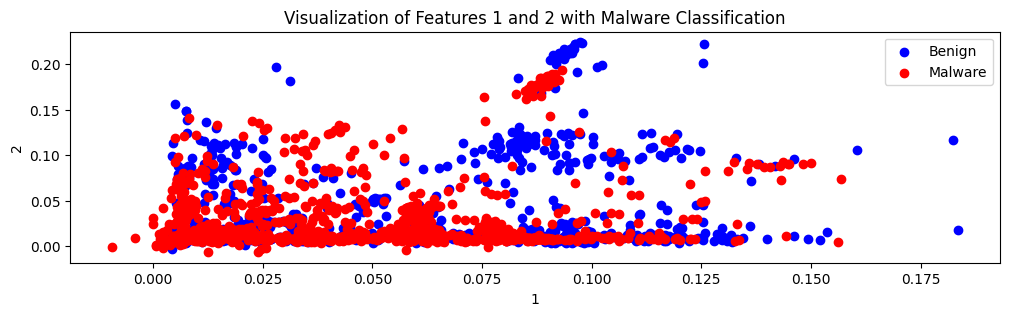

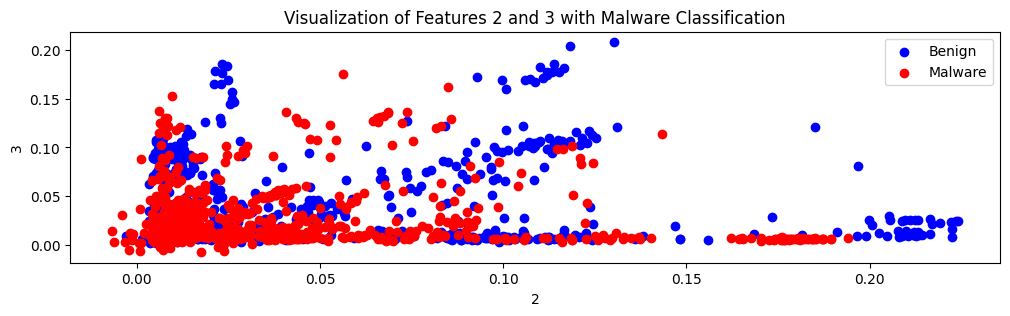

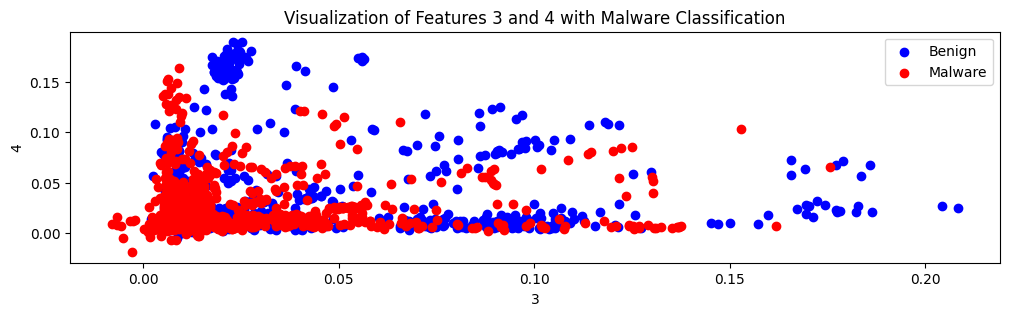

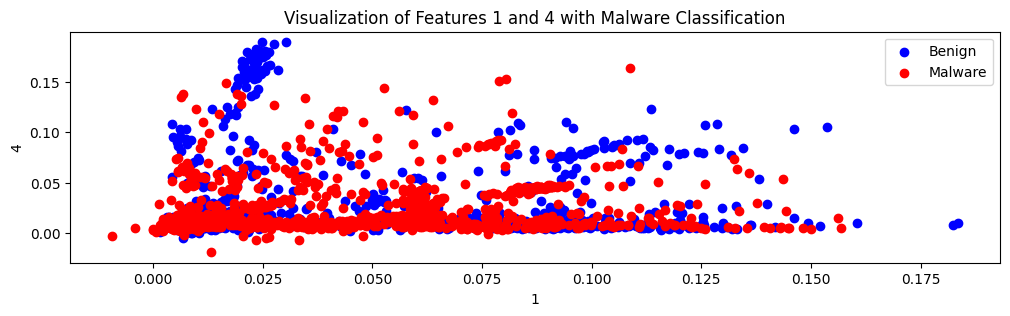

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_features(data,  label_column='label'):
    ##########################
    f1 = 1
    f2 = 2
    features = data.iloc[:, [f1, f2]].to_numpy()
    labels = data[label_column].to_numpy()

    plt.figure(figsize=(12, 3))
    plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='blue', label='Benign')
    plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='red', label='Malware')

    # Add labels and title
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"Visualization of Features {f1} and {f2} with Malware Classification")
    plt.legend()

    ##########################
    f1 = 2
    f2 = 3
    features = data.iloc[:, [f1, f2]].to_numpy()
    labels = data[label_column].to_numpy()

    plt.figure(figsize=(12, 3))
    plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='blue', label='Benign')
    plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='red', label='Malware')

    # Add labels and title
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"Visualization of Features {f1} and {f2} with Malware Classification")
    plt.legend()

    ##########################
    f1 = 3
    f2 = 4
    features = data.iloc[:, [f1, f2]].to_numpy()
    labels = data[label_column].to_numpy()

    plt.figure(figsize=(12, 3))
    plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='blue', label='Benign')
    plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='red', label='Malware')

    # Add labels and title
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"Visualization of Features {f1} and {f2} with Malware Classification")
    plt.legend()


    plt.show()

    ##########################
    f1 = 1
    f2 = 4
    features = data.iloc[:, [f1, f2]].to_numpy()
    labels = data[label_column].to_numpy()

    plt.figure(figsize=(12, 3))
    plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='blue', label='Benign')
    plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='red', label='Malware')

    # Add labels and title
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"Visualization of Features {f1} and {f2} with Malware Classification")
    plt.legend()


    plt.show()


# Call the visualization function with appropriate indices (assuming labels are in the last column)
# Three subplots in a row
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # Adjust spacing between plots
visualize_features(data)
# visualize_features(data, 1, 2)
# visualize_features(data, 2, 3)
# visualize_features(data, 3, 4)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [81]:
def load_df_data():
    X = data.drop(['label'],axis=1).values
    y = data['label'].values
    print("Total samples: "+str(X.shape))
    return train_test_split(X, y, test_size=0.2)


def trainRF(X_train, y_train):
  # Print sample counts
  print("Training samples:", X_train.shape[0])
  print("Testing samples:", X_test.shape[0])

  # Train the Random Forest model
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)
  print(f"DONE TRAINING {X_train.shape[0]} samples")

  # Save model (optional)
  joblib.dump(rf, "rf_model.joblib")

def testRF(X_test, y_test, model_path):
  print(f"--- TESTING {model_path[9:-7]} ---")
  loaded_rf = joblib.load(model_path)
  predictions = loaded_rf.predict(X_test)

  cm = confusion_matrix(y_test, predictions)

  # Calculate evaluation metrics
  TP = cm[1, 1]
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  accuracy = accuracy_score(y_test, predictions)
  recall = TP / (TP + FN)  # True positive rate
  precision = TP / (TP + FP)  # Positive predictive value
  F1 = 2 * (precision * recall) / (precision + recall)

  print("True Positives:", TP, end=" | ")
  print("True Negatives:", TN)
  print("False Positives:", FP, end =" | ")
  print("False Negatives:", FN)
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("F1-score:", F1)
  print(f"-------------------------\n")



In [82]:
X_train, X_test, y_train, y_test = load_df_data()
trainRF(X_train, y_train)

Total samples: (2442, 100)
Training samples: 1953
Testing samples: 489
DONE TRAINING 1953 samples


In [83]:
model_path = "/content/rf_model.joblib"
testRF(X_test, y_test, model_path)

--- TESTING rf_model ---
True Positives: 284 | True Negatives: 172
False Positives: 24 | False Negatives: 9
Accuracy: 0.9325153374233128
Recall: 0.9692832764505119
F1-score: 0.9450915141430948
-------------------------

